In [1]:
%%capture
from jupyterthemes import jtplot
jtplot.style()
import numpy as np
from landlab import FieldError
from landlab.utils import get_watershed_mask
import xarray as xr
import pandas as pd
import scipy
import gdal
from scipy import ndimage
from scipy.ndimage.filters import *
import os
import math
from osgeo import osr
from fractions import Fraction
import timeit
import matplotlib.pyplot as plt
#import matplotlib.image as mpimg
%matplotlib inline
import random
# import plotting tools
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib as mpl
from landlab.plot.imshow import imshow_grid 
# import necessary landlab components
from landlab import RasterModelGrid, HexModelGrid
from landlab.components import FlowAccumulator, FlowRouter, LakeMapperBarnes, SinkFillerBarnes
from landlab.components import(FlowDirectorD8, 
                               FlowDirectorDINF, 
                               FlowDirectorMFD, 
                               FlowDirectorSteepest)
from landlab.components import DepressionFinderAndRouter
# import landlab plotting functionality
from landlab.plot.drainage_plot import drainage_plot
from pylab import show, figure

# create a plotting routine to make a 3d plot of our surface. 
def surf_plot(mg, surface='topographic__elevation', 
              title='Surface plot of topography', colormap = cm.gray):
    
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    # Plot the surface.
    Z = (mg.at_node[surface].reshape(mg.shape))#[y1:y2, x1:x2]
    color = colormap((Z-Z.min())/(Z.max()-Z.min()))
    surf = ax.plot_surface(mg.node_x.reshape(mg.shape),#[y1:y2, x1:x2]
                           mg.node_y.reshape(mg.shape),#[y1:y2, x1:x2]
                           Z,
                           rstride=1, cstride=1,
                           facecolors=color,
                           linewidth=0.,
                           antialiased=False)
    ax.view_init(elev=35, azim=-120)
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Elevation')
    plt.title(title)
    plt.show()

In [2]:
location = (r'C:/PhD/junk')
os.chdir(location)

input_geotiff = gdal.Open('fann_2013_1ma.tif')
initial_resolution = 1
x = np.array(input_geotiff.GetRasterBand(1).ReadAsArray())
input_DEM = x[1500:2000, 2000:3000]

input_outlets = gdal.Open('gully_1_a.tif')
initial_resolution = 1
o = np.array(input_outlets.GetRasterBand(1).ReadAsArray())
outlets = o[1500:2000, 2000:3000]

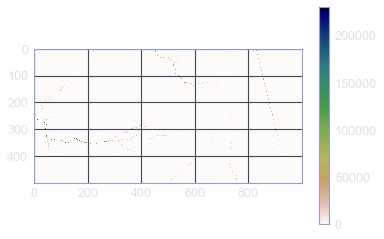

In [18]:
plt.imshow(input_DEM, cmap="gist_earth_r")
plt.colorbar()

In [4]:
flow_acc_surf = np.copy(input_DEM).astype('float64');

## First run D8

In [29]:
mg_D8 = RasterModelGrid((flow_acc_surf.shape[0],flow_acc_surf.shape[1]), spacing=(1, 1));
z1 = mg_D8.add_field('topographic__elevation', flow_acc_surf, at = 'node')

In [35]:
sfb = SinkFillerBarnes(mg_D8, method = 'Steepest', ignore_overfill = True);
sfb.run_one_step();
fr = FlowAccumulator(mg_D8, flow_director='D8')
fr.run_one_step()

In [36]:
da_D8 = np.array(mg_D8.at_node['drainage_area'].round(4))
drainage_area_D8 = da_D8.reshape(mg_D8.shape).astype('float64');
grid_nodes = np.array(mg_D8.nodes.reshape(mg_D8.shape))

In [37]:
find_outlet_ids = grid_nodes * outlets

In [38]:
np.unique(find_outlet_ids)

array([     0, 321480, 322480])

### Extract the watershed mask

In [41]:
# The second argument to get_watershed_mask is one of the node IDs found above.
wsm = np.array(get_watershed_mask(mg_D8, 322480).reshape(mg_D8.shape).astype(int))

In [56]:
watershed_D8 = wsm * drainage_area_D8

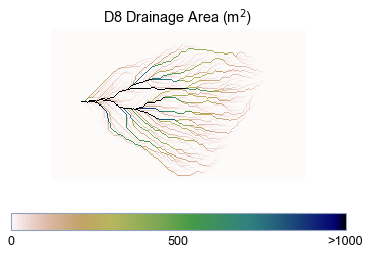

In [57]:
fig, ax = plt.subplots()

cax = ax.imshow(watershed_D8[250:400, 450:700], interpolation='nearest', 
                cmap='gist_earth_r', vmax = 1000)
ax.set_title('D8 Drainage Area (m$^2$)', color = 'Black')

cbar = fig.colorbar(cax, ticks=[0, 500, 1000], orientation='horizontal')
cbar.ax.set_xticklabels(['0', '500', '>1000'], color = 'Black')
plt.axis('off')
plt.show()

## Now run M4

In [44]:
mg_M4 = RasterModelGrid((flow_acc_surf.shape[0],flow_acc_surf.shape[1]), spacing=(1, 1));
z1 = mg_M4.add_field('topographic__elevation', flow_acc_surf, at = 'node')

In [45]:
sfb = SinkFillerBarnes(mg_M4, method = 'Steepest', ignore_overfill = True);
sfb.run_one_step();
fa = FlowAccumulator(mg_M4,
                    surface = 'topographic__elevation',
                    flow_director = 'FlowDirectorMFD',
                    diagonals = False);
(flow_acc, q) = fa.accumulate_flow();
fd = FlowDirectorMFD(mg_M4, 'topographic__elevation', diagonals = False);
fd.direct_flow();

In [46]:
da_M4 = np.array(mg_M4.at_node['drainage_area'].round(4))
drainage_area_M4 = da_M4.reshape(mg_M4.shape).astype('float64');

In [47]:
watershed_M4 = wsm * drainage_area_M4

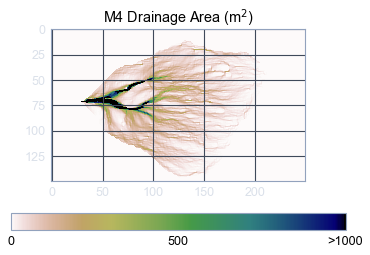

In [29]:
fig, ax = plt.subplots()

cax = ax.imshow(watershed_M4[250:400, 450:700], interpolation='nearest', 
                cmap='gist_earth_r', vmax = 1000)
ax.set_title('M4 Drainage Area (m$^2$)', color = 'Black')

cbar = fig.colorbar(cax, ticks=[0, 500, 1000], orientation='horizontal')
cbar.ax.set_xticklabels(['0', '500', '>1000'], color = 'Black')
#plt.axis('off')
plt.show()

## Now run M8

In [69]:
mg_M8 = RasterModelGrid((flow_acc_surf.shape[0],flow_acc_surf.shape[1]), spacing=(1, 1));
z1 = mg_M8.add_field('topographic__elevation', flow_acc_surf, at = 'node')

In [70]:
sfb = SinkFillerBarnes(mg_M8, method = 'Steepest', ignore_overfill = True);
sfb.run_one_step();
fa = FlowAccumulator(mg_M8,
                    surface = 'topographic__elevation',
                    flow_director = 'FlowDirectorMFD',
                    diagonals = True);
(flow_acc, q) = fa.accumulate_flow();
fd = FlowDirectorMFD(mg_M8, 'topographic__elevation', diagonals = True);
fd.direct_flow();

In [71]:
da_M8 = np.array(mg_M8.at_node['drainage_area'].round(4))
drainage_area_M8 = da_M8.reshape(mg_M8.shape).astype('float64');

In [72]:
watershed_M8 = wsm * drainage_area_M8

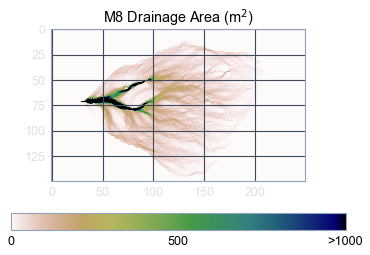

In [73]:
fig, ax = plt.subplots()

cax = ax.imshow(watershed_M8[250:400, 450:700], interpolation='nearest', 
                cmap='gist_earth_r', vmax = 1000)
ax.set_title('M8 Drainage Area (m$^2$)', color = 'Black')

cbar = fig.colorbar(cax, ticks=[0, 500, 1000], orientation='horizontal')
cbar.ax.set_xticklabels(['0', '500', '>1000'], color = 'Black')
#plt.axis('off')
plt.show()

# Now run DINF

In [64]:
mg_DINF = RasterModelGrid((flow_acc_surf.shape[0],flow_acc_surf.shape[1]), spacing=(1, 1));
z1 = mg_DINF.add_field('topographic__elevation', flow_acc_surf, at = 'node')

In [65]:
sfb = SinkFillerBarnes(mg_DINF, method = 'Steepest', ignore_overfill = True);
sfb.run_one_step();
fa = FlowAccumulator(mg_DINF,
                    surface = 'topographic__elevation',
                    flow_director = 'FlowDirectorDINF');
(flow_acc, q) = fa.accumulate_flow();
fd = FlowDirectorMFD(mg_DINF, 'topographic__elevation', diagonals = True);
fd.direct_flow();

In [66]:
mg_DINF = np.array(mg_DINF.at_node['drainage_area'].round(4))
drainage_area_DINF = mg_DINF.reshape(mg_D8.shape).astype('float64');

In [67]:
watershed_DINF = wsm * drainage_area_DINF

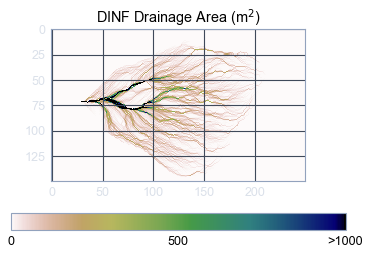

In [68]:
fig, ax = plt.subplots()

cax = ax.imshow(watershed_DINF[250:400, 450:700], interpolation='nearest', 
                cmap='gist_earth_r', vmax = 1000)
ax.set_title('DINF Drainage Area (m$^2$)', color = 'Black')

cbar = fig.colorbar(cax, ticks=[0, 500, 1000], orientation='horizontal')
cbar.ax.set_xticklabels(['0', '500', '>1000'], color = 'Black')
#plt.axis('off')
plt.show()

## Write out file

In [ ]:
out_array = np.ones(x.shape)
out_array[out_array == 1] = np.nan
out_array[1500:2000, 2000:3000] = watershed_D8

In [97]:
prj = input_geotiff.GetProjection()
srs=osr.SpatialReference(wkt=prj)
if srs.IsProjected:
    print(srs.GetAttrValue('projcs'))
print(srs.GetAttrValue('geogcs'))

WGS_1984_Transverse_Mercator
WGS 84


In [34]:
def np_array_to_Geotiff(newfile, original_tiff, np_array, dtype):
    
    cols = np_array.shape[1]
    rows = np_array.shape[0]
    originX, pixelWidth, b, originY, d, pixelHeight = original_tiff.GetGeoTransform() 
    driver = gdal.GetDriverByName('GTiff')
    GDT_dtype = gdal.GDT_Unknown
    if dtype == "Float64": 
        GDT_dtype = gdal.GDT_Float64
    elif dtype == "Float32":
        GDT_dtype = gdal.GDT_Float32
    else:
        print("Not supported data type.")
    
    if np_array.ndim == 2:
        band_num = 1
    else:
        band_num = np_array.shape[2]

    outRaster = driver.Create(newfile, cols, rows, band_num, GDT_dtype)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    
    # Loop over all bands.
    for b in range(band_num):
        outband = outRaster.GetRasterBand(b + 1)
    
        # Read in the band's data into the third dimension of our array
        if band_num == 1:
            outband.WriteArray(np_array)
        else:
            outband.WriteArray(np_array[:,:,b])

    # setteing srs from input tif file.
    prj=original_tiff.GetProjection()
    outRasterSRS = osr.SpatialReference(wkt=prj)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()
    outRaster = None
    
    return outRaster

In [50]:
np_array_to_Geotiff('Watershed_D8.tif', input_geotiff, out_array, watershed_D8.dtype)

C:\Users\sjwal\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  
